<img src="https://raw.githubusercontent.com/datainterviewpro/brand/main/PCIP%20logo.png" width="200">

# A/B Testing Project Solution 

## 1. Experiment: Order Bump

You're a data scientist working at an e-commerce startup. The revenue in product sales from last quarter doesn't look so good, so your team is brainstorming ideas to encourage more purchases. One proposal is using so-called ["order bump"](https://accessally.com/blog/order-bump-examples/) to get customers to add more items to their cart before they check out. As the only data scientist on the team, your colleagues naturally turn to you and ask: *"Do you think this might be a good idea? Would you help the team find out?"*

<img src="https://orderbump.io/images/og-order-bump.jpg" width="450">

### Q1. Use your intuitions and list reasons why you think order bump may or may not be a good idea. (Think both for your company and in your customers' shoes.)

- **Why it may be a good idea**: If used cleverly and organically, order bump is a great way to increase revenue per customer. You can find several success stories [here](https://accessally.com/blog/order-bump-examples/). For instance, if you recommend items or services (e.g., Apple Care) customers actually need or offer good deals that are genuinely attractive, they may appreciate the suggestions.
- **When it may hurt**: However, if an order bump has no intrinsic appeal or is presented in an intrusive way (e.g., a pop-up window), customers may be turned off. Not only will they not accept the bump, they may even give up buying what they originally wanted to buy. If bad experience happens again, they may churn and stop being your customers.

Now, the data scientist in you says the gold standard for deciding whether this is a good idea is to **run an A/B test**. In the new treatment variant, customers are nudged to add more items to their cart by the order bump whereas in the control variant, it's business as usual: Customers check out whatever they add to the cart without being prompted to add more.

### Q2: What metrics would you track in this experiment? List at least 3. If you can only pick one success metric for this experiment, which one would it be and why?

To see if order bump is a success, I'd consider the following behaviors, along with metrics (<u>underlined</u>) that can be use to track them:
1. **Do customers accept the order bump?** We can look at the <u>acceptance rate</u> (# of order bumps clicked / # order bumps shown) of order bumps. If the order bump is shown as a pop-up window or otherwise has to be "dealt with", we can also track the <u>dismiss rate</u> (# of orders bumps closed / # order bumps shown). While these metrics tell us a lot about whether a feature is appealing or annoying, they only exist in treatment but control (where there is no order bump). As such, we can't use them as experiment metrics.
2. **Do order bumps bring in more money for us?** After all, this is why we decide to run this experiment, to increase the revenue for our e-commerce. We can track the <u>total revenue</u> in each variant as well as the <u>average revenue per customer</u> to see if the order bump bumps them up. Since we may not have the same number of units in each variant, the total revenue metric may not be the best to use. Moreover, total metrics often have higher variances than per-customer metrics, leading to a lack of power.  
3. **Or are does it backfire?** It's possible that customers dislike order bumps so much that they don't even proceed to check out and don't even return in the future. To see if our nightmares come true, we can track the <u>cart abandonment rate</u> (# of customers who don't check out / # of customers who add items to cart) in each variant as well as <u>retention</u> and <u>churn</u> (which are a bit tricky to define for [e-commerce](https://towardsdatascience.com/modeling-customer-churn-for-an-e-commerce-business-with-python-874315e688bf)). However, since we may not see customers churn so quickly and it's too late to take actions if they do, retention and churn are not good experiment metrics.

Taking it all together, I'll use **average revenue per customer** as the success metric, which has many nice properties (see [this post](https://www.yuan-meng.com/posts/metrics/) for more characteristics of good metrics):
1. **Goal-oriented**: It tracks the goal of the product and our company, i.e., stimulating purchase behaviors
2. **Measurable**: It can be more easily measured within the experiment duration, than, say churn and retention
3. **Low variance**: Average revenue per customer is quite variant, but the variance is lower than total revenues

Your manager says, great, the engineers will help you implement an A/B test! The data came back after a while. Now it's you turn!

## 2. Experiment Data

The experiment data is stored in 3 separate CSV files as follws:

1. Transaction data before the experiment: `transactions_pre.csv`

- `customer_id` (data type: integer): unique identifier of each customer
- `transaction_date` (data type: datetime): the date on which the transaction happened
- `amount_usd` (data type: float): the US dollar amount paid by the customer in the transaction
     
2. Transaction data after the experiment: `transactions_post.csv` (same structure as the pre-test data)
     
3. Metadata on experiment assignments: `assignment.csv`
- `customer_id` (data type: integer): unique identifier of each customer
- `variant` (data type: string): whether the customer was assigned to the experiment or the control variant

<div class="alert alert-block alert-info"> <b>NOTE</b> The data has been pre-processed but you shouldn't assume it's 100% clean. You may still need to deal with missing values and outliers. </div> 

<div class="alert alert-block alert-warning"> <b>CAUTION</b> If you use parametric methods such as two-sample t-tests to analyze the data, you need to think about the test assumptions and your data distributions. Read <a href="https://gnarlyware.com/blog/fooled-by-average-customer-revenue/">this article</a> if you're curious about how some key metrics in e-commerce are distributed. </div>



## 3. Experiment Analysis

### Q3: What is your hypothesis regarding the outcome? Please state both the null hypothesis ($H_0$) and the alternative hypothesis ($H_1$). For your alternative hypothesis, should it be one-tailed or two-tailed? Why?

Let $\mu_t$ be the average revenue per customer in the treatment variant and $\mu_c$ the same metric in the control variant.
- **Null hypothesis ($H_0$)**: $\mu_t = \mu_c$
- **Alternative hypothesis ($H_1$)**: $\mu_t \neq \mu_c$

Note that I used a **two-tailed** alternative hypothesis because order bump may either hurt or help; there's no reason to lean one way or the other.

---
Time to take a close look at the data and understand the impact of order bump!

Below are some libraries you may find help. Feel free to use other libraries or languages you normally use to analyze data.

In [ ]:
# handle data
import pandas as pd
import numpy as np

# visualize data
import seaborn as sns
import matplotlib.pyplot as plt

# run tests
from scipy import stats
import statsmodels.stats.api as sms

# aesthetics
sns.set(font_scale=2)
pd.options.mode.chained_assignment = None

In [ ]:
# load all the data
df_pre = pd.read_csv("transactions_pre.csv")
df_post = pd.read_csv("transactions_post.csv")
df_meta = pd.read_csv("assignment.csv")

### Q4: Does the data pass sanity checking? Please consider outliers, random assignments, pre-test differences between variants, and other factors you deem important.

#### 1. Outliers
Let's begin by checking for outliers and anomalies in the transaction data.

In [ ]:
# pre-treatment summary statistics
df_pre["amount_usd"].describe()

count    443748.000000
mean         24.962695
std         950.452061
min           0.900000
25%           1.990000
50%           4.170000
75%          12.800000
max      109313.450000
Name: amount_usd, dtype: float64

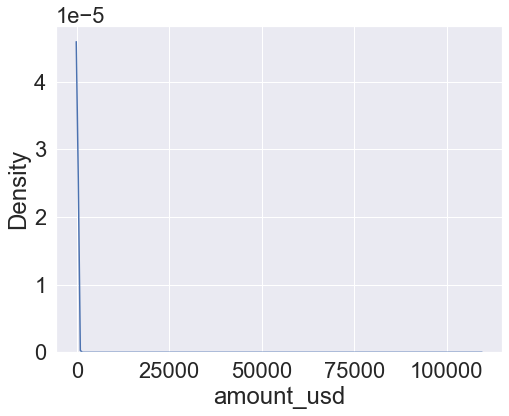

In [ ]:
# plot the distribution
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df_pre, x="amount_usd")
plt.show()

In [ ]:
# pre-treatment summary statistics
df_post["amount_usd"].describe()

count    398013.000000
mean         37.246828
std        1271.811492
min           0.900000
25%           2.130000
50%           5.550000
75%          17.310000
max      109954.310000
Name: amount_usd, dtype: float64

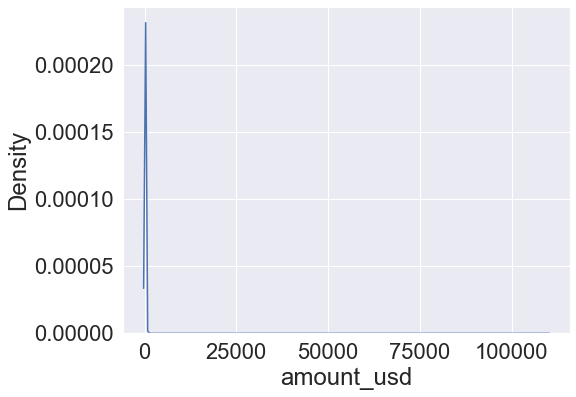

In [ ]:
# plot the distribution
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df_post, x="amount_usd")
plt.show()

These ~400k transactions are unlikely real. Outliers or, worse, potential measurement errors, may mess up the hypothesis testing. In machine learning, there are many fancy techniques for detecting outliers, such as the [Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest), the [Random Cut Forest](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html) etc.. In this exercise, I'll go with a more traditional method: Since average revenue per customer is not normally distributed, I'll first log transform `amount_usd` and then remove transactions whose values are outside of the 99th percentile.

There's something tricky, though: Percentiles are relative, so we may want to look at transaction data in both periods to establish a common standard for what counts as outliers.

In [ ]:
# find the cutoff for what counts as outliers
df_both = pd.concat([df_pre, df_post])
df_both["log_amount_usd"] = df_both["amount_usd"].apply(lambda x: np.log(x))
cutoff = df_both["log_amount_usd"].quantile(0.99)

In [ ]:
def remove_outliers(df, cutoff):
    # log-transform transaction amount
    df["log_amount_usd"] = df["amount_usd"].apply(lambda x: np.log(x))

    # create a new dataframe without outliers
    df_new = df[df["log_amount_usd"] <= cutoff]

    # return new dataframe
    return df_new

In [ ]:
# remove outliers in both pre- and post-test data
df_pre_clean = remove_outliers(df_pre, cutoff)
df_post_clean = remove_outliers(df_post, cutoff)

Now we can aggregate the data and calculate average revenue per user.

In [ ]:
def aggregate_by_customer(df):

    # get mean values for each customer
    revenue = df.groupby("customer_id").mean().reset_index()

    # only select columns we need
    revenue = revenue[["customer_id", "amount_usd"]]
    revenue.rename(columns={"amount_usd": "avg_revenue"}, inplace=True)

    # return new dataframe
    return revenue

In [ ]:
# aggregrate in each period
agg_pre = aggregate_by_customer(df_pre_clean)
agg_post = aggregate_by_customer(df_post_clean)

#### 2. Random assignments

If assignment is random, there should be the same number of units in each variant through out the experiment. To see if this is the case, we need to join the data first. **What type of JOIN, though?** I think LEFT JOIN is most appropriate: If someone bought something before the experiment began but didn't make any transactions afterwards, it could indicate a lost interest. If we use INNER JOIN, we lose such information.

In [ ]:
# LEFT JOIN data in each period
df = agg_pre.merge(agg_post, on="customer_id", how="left", suffixes=["_pre", "_post"])
df.fillna(0, inplace=True)  # if no transaction happened, treat the amount as 0
# find the variant of each customer
df = df.merge(df_meta, on="customer_id")

In [ ]:
# how many units are in each variant?
df.groupby("variant").size()

variant
control      9941
treatment    9921
dtype: int64

The number is really close. If you're really paranoid about sample ratio mismatch (SRM), we can check.

In [ ]:
def check_srm(df, alpha):

    # sample size in each variant
    n_c = df.groupby("variant").size()["control"]
    n_t = df.groupby("variant").size()["treatment"]

    # "success rate" (being assigned to treatment)
    p_t = n_t / (n_t + n_c)

    # variance (Normal approximation of Binomial)
    var = 0.5 * (1 - 0.5)
    # standard error
    se = np.sqrt(var / (n_t + n_c))

    # z score
    z_score = (p_t - 0.5) / se

    # p value
    p_value = 1 - stats.norm.cdf(z_score)

    # print result
    if p_value < alpha:
        print(f"found sample ratio mismatch: p(treatment) = {p_t}, p = {p_value}")
    else:
        print(f"assignment looks random! p(treatment) = {p_t}, p={p_value}")

In [ ]:
# check for sample ratio mismatch
check_srm(df, 0.05)

assignment looks random! p(treatment) = 0.49949652602960426, p=0.5564251629722654


#### 3. Pre-test differences

In [ ]:
# isolate pre-test data
treatment_pre = df[df["variant"] == "treatment"]["avg_revenue_pre"]
control_pre = df[df["variant"] == "control"]["avg_revenue_pre"]

The t-test quantifies the difference between the arithmetic means of the two samples. The p-value quantifies the probability of observing as or more extreme values assuming the null hypothesis, that the samples are drawn from populations with the same population means, is true. A p-value larger than a chosen threshold (e.g. 5% or 1%) indicates that our observation is not so unlikely to have occurred by chance. Therefore, we do not reject the null hypothesis of equal population means. 

If the p-value is smaller than the threshold (e.g. 5% or 1%), then we have evidence against the null hypothesis of equal population means.

In [ ]:
# test for difference in treatment vs. control means
stats.ttest_ind(treatment_pre, control_pre)

Ttest_indResult(statistic=-7.197679548774967, pvalue=6.342861266582803e-13)

Too bad, the average revenue per customer is already different in the pre-test period! This is a strong indicator that customers are not randomly assigned to each variant.

### Q5: If variants were already different before the experiment, how would you analyze data more appropriately? (**Hint**: Instead of just comparing metric values in the post-test data, you can compute the post- vs. pre-test change for each customer and compare the average change between variants.)

This is really not ideal, but hey, when life gives you lemons, you gotta make some lemonade... So as the hint suggests, we can compute the change in each customer's average revenue. If the treatment has an effect on customers' behavior, then the average change should be different in each variant.

In [ ]:
# compute change in average revenue per customer
df["avg_rev_delta"] = df["avg_revenue_post"] - df["avg_revenue_pre"]

### Q6: Did order bump impact the metric you chose? What statistical tests did you conduct to answer this question? Were the assumptions behind them met? 

In [ ]:
# isolate data for comparison
treatment = df[df["variant"] == "treatment"]["avg_rev_delta"]
control = df[df["variant"] == "control"]["avg_rev_delta"]

We can use a two-sample t-test to answer this question. Below are some basic assumptions behind t-test:

- **Independence** between and within groups
- **Normality** in each group
- To pool variance, each group should have **equal variance**

We have no evidence for or again whether the customers are dependent somehow (e.g., in the same household), which is common for online experiments, so don't fret too much about this. After testing for normality (detailed below), I found that the metric is normally distributed in neither variant. However, since we have a large sample, it's likely that the sampling distribution is still normal (central limit theorem). As for the last assumption, pooling variance or not usually doesn't make a huge difference.

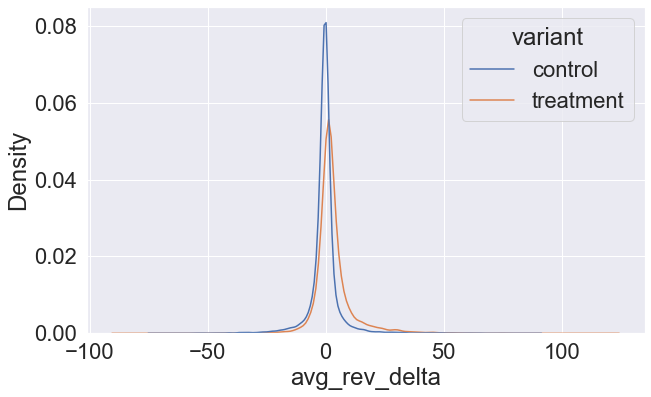

In [ ]:
# plot the distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="avg_rev_delta", hue="variant")
plt.show()

In [ ]:
def test_normality(data, alpha):
    # conduct normality test D’Agostino, R. B. (1971)
    k2, p = stats.normaltest(data)

    # print result
    if p < alpha:  # null hypothesis: data comes from a normal distribution
        print("The data is NOT normally distributed :(")
    else:
        print("The data is normally distributed :)")

In [ ]:
# test normality in each variant
test_normality(treatment, 0.05)
test_normality(control, 0.05)

The data is NOT normally distributed :(
The data is NOT normally distributed :(


In [ ]:
# test for difference in treatment vs. control changes
stats.ttest_ind(treatment, control)

Ttest_indResult(statistic=31.208213551875527, pvalue=8.888175777344926e-209)

For treatment, the average revenue per customer increased much more than it did for control.

In [ ]:
# let's get 95% CI
sms.CompareMeans(sms.DescrStatsW(treatment), sms.DescrStatsW(control)).tconfint_diff(
    usevar="unequal"
)

(3.2002323886606137, 3.629270551572163)

This is confirmed by 95% CI: The lower bound is greater than 0.

## 4. Make a Decision

### Q7: Based on the results, would you recommend for launching the order bump feature? If the results are not ideal, what actions would you recommend the team to take?

<img src="https://i0.wp.com/workchronicles.com/wp-content/uploads/2021/08/Decision-vs-Outcome.png?w=2000&ssl=1" width="450">

Normally I'd advocate for a launch:

1. Compared to control, the treatment improved significantly more in terms of average revenue per customer
2. Average revenue per customer is absolutely key to the survival of my company and we an urgent need need to improve it

In this case, something seems wrong with randomization such that the average revenue per customer was different between variants. I'd ask the engineers to check the implementations. Otherwise, after we launch order bump, the same error may haunt other customers.